In [1]:
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve


In [2]:
# Load impulse response
ir_path = 'audio/impulse_response.wav'
ir, ir_sr = librosa.load(ir_path, sr=None)

# Load dry input
dry_path = 'audio/dry_audio.wav'
dry, dry_sr = librosa.load(dry_path, sr=None)

print(f"IR sample rate: {ir_sr}, Dry sample rate: {dry_sr}")


IR sample rate: 44100, Dry sample rate: 48000


In [3]:
if ir_sr != dry_sr:
    ir = librosa.resample(ir, orig_sr=ir_sr, target_sr=dry_sr)
    ir_sr = dry_sr


In [4]:
# Convolve using FFT for speed
wet = fftconvolve(dry, ir, mode='full')

# Normalize
wet /= np.max(np.abs(wet))

# Trim or fade if needed (optional)


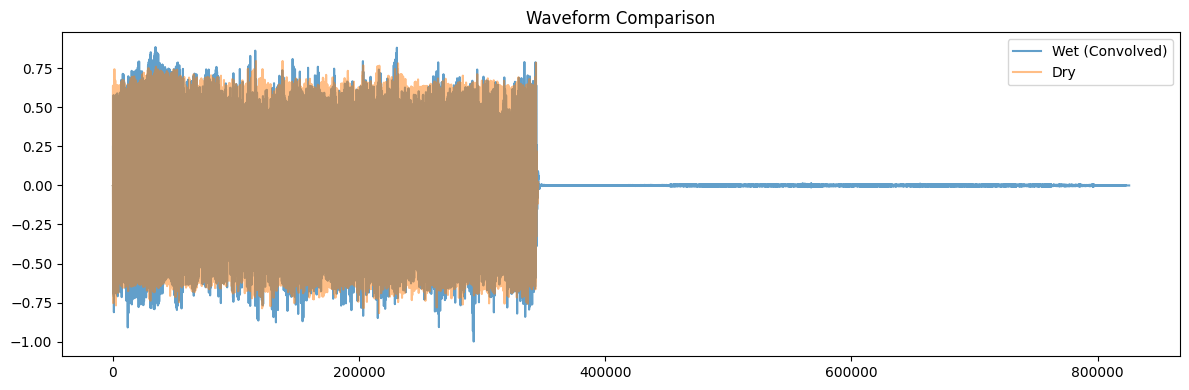

In [5]:
# Plot waveforms
plt.figure(figsize=(12, 4))
plt.plot(wet, alpha=0.7, label='Wet (Convolved)')
plt.plot(dry, alpha=0.5, label='Dry')
plt.title('Waveform Comparison')
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
sf.write('audio/output_wet.wav', wet, dry_sr)
print("Saved output to audio/output_wet.wav")


Saved output to audio/output_wet.wav
